# Linear Regression and SVM Model Selection
## Cross Validation and Bootstrapping

Here I will be looking at data generated by particle physicists to test whether machine learning can help classify whether certain particle decay experiments identify the presence of a Higgs Boson. One does not need to know anything about particle physics to do well here, but if you are curious, full feature and data descriptions can be found here:

- https://www.kaggle.com/c/higgs-boson/data
- http://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf

The goal is to learn to use cross-validation for model selection as well as bootstrapping for error estimation. We’ll also use learning curve analysis to understand how well different algorithms make use of limited data.

### Data preparation 
I will create a data preparation and cleaning function that does the following:
- Has a single input that is a file name string
- Reads data (the data is comma separated, has a row header and the first column `EventID` is the index) into a pandas `dataframe`
- Cleans the data
  - Convert the feature `Label` to numeric (choose the minority class to be equal to 1)
    - Create a feature `Y` with numeric label
    - Drop the feature `Label`
  - If a feature has missing values (i.e., `-999`): 
    - Create a dummy variable for the missing value
      - Call the variable `orig_var_name` + `_mv` where `orig_var_name` is the name of the actual var with a missing value
      - Give this new variable a 1 if the original variable is missing
    - Replace the missing value with the average of the feature (compute the mean on records where the value isn't missing).
- After the above is done, rescales the features so that each feature has zero mean and unit variance (hint: look up sklearn.preprocessing)
- Returns the cleaned and rescaled dataset


In [2]:
from sklearn.preprocessing import StandardScaler

def cleanBosonData(infile_name):
    df = pd.read_csv(infile_name, index_col=0) #read data into dataframe and set EventID as index
    index = df.index # save this index
    
    b_count, s_count = df["Label"].isin(["b"]).sum(), df["Label"].isin(["s"]).sum() # count the number of b's and s's
    
    
    
    if b_count < s_count:  # convert feature Label to numeric feature Y (minority class to 1)
        df["Y"] = df["Label"].apply(lambda data: 1 if data == "b" else 0)
    else:
        df["Y"] = df["Label"].apply(lambda data: 1 if data == "s" else 0)
        
    df.drop(columns=["Label"], axis=1, inplace=True) 
    
    for i in df.columns:  # missing value handling
        new_col = i + "_mv"
        df[new_col] = df[i].apply(lambda data: 1 if data == -999 else 0)
        mean = df[i].loc[df[new_col] == 0].mean()
        df[i] = df[i].replace(-999, mean)
    
    df_Y = df["Y"]
    new_df = df.loc[:, df.columns != 'Y']
    
    data_clean = pd.DataFrame(StandardScaler().fit_transform(new_df),columns = new_df.columns, index=index) #rescaling the features except for Y
    data_clean = data_clean.loc[:, (data_clean != 0).any(axis=0)] # remove the columns with zero's only. 
    data_clean = pd.concat([data_clean, df_Y], axis=1)
    
    return data_clean

### Basic evaluations 
I will build an out-of-the box logistic regression (LR) model and support vector machine (SVM). I will then plot ROC for the LR and SVM model.

1\. I will clean the two data files included in this assignment (`data/boson_training_cut_2000.csv` and `data/boson_testing_cut.csv`) by using the function defined above, and use them as training and testing data sets.

In [3]:
data_train = cleanBosonData("boson_training_cut_2000.csv")
data_test = cleanBosonData("boson_testing_cut.csv")

In [5]:
data_train.head(2)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv,Y
EventId,,,,,,,,,,,,,,
100000,0.398362,0.092601,0.491173,-0.444021,-1.650125e+00,-1.135322e+00,1.873193e+00,0.888048,1.12005,-0.405265,-1.591164,-1.591164,-1.591164,1
100001,0.863396,0.608117,0.639363,-0.120744,-4.978417e-16,2.786711e-16,6.148512e-17,1.421917,-0.80639,-0.405265,0.628471,0.628471,0.628471,0


In [6]:
data_test.head(2)

,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,DER_mass_MMC_mv,DER_deltaeta_jet_jet_mv,DER_mass_jet_jet_mv,DER_prodeta_jet_jet_mv,Y
EventId,,,,,,,,,,,,,,
300000,-0.121335,1.455304,0.099593,-0.447028,-4.699335e-16,0.0,5.739942e-17,0.007415,0.498029,-0.422979,0.641958,0.641958,0.641958,0
300001,-1.067373,-0.715757,-0.854408,-0.103307,-4.699335e-16,0.0,5.739942e-17,-0.758743,1.730043,-0.422979,0.641958,0.641958,0.641958,0


2\. On the training set, I will build the following models:

- A logistic regression using sklearn's `linear_model.LogisticRegression()`. For this model, `C=1e30` is used.
- An SVM using sklearn's `svm.svc()`. For this model, `kernel="linear"`.

For each model above, I will plot the ROC curve of both models on the same plot. I will of course use the test set for computing and plotting.

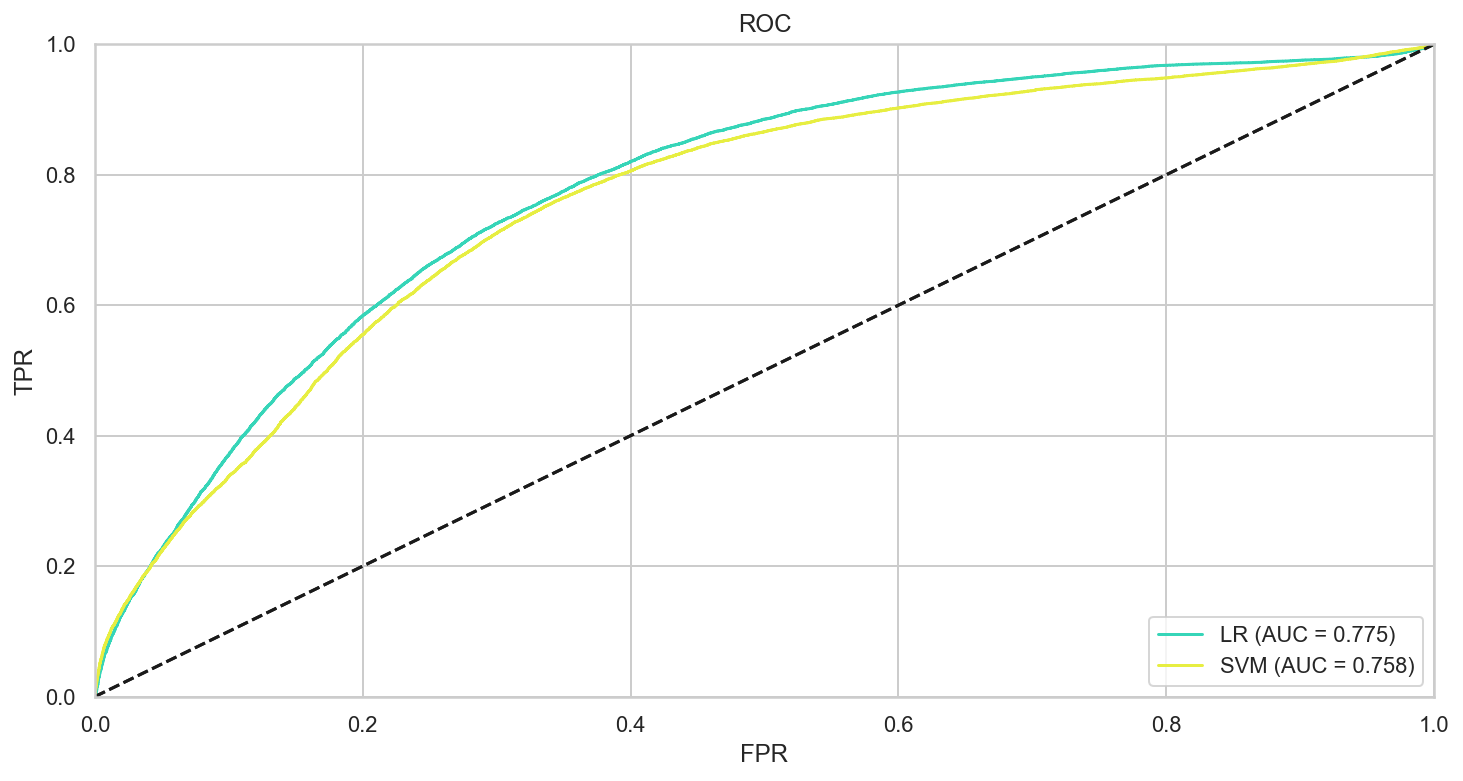

In [19]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

Y = data_train['Y']
X = data_train.drop('Y', 1)

lr = LogisticRegression(C=1e30).fit(X, Y)
preds_lr = lr.predict_proba(data_test.drop("Y", 1))[:,1]


svm = SVC(kernel="linear").fit(X, Y)
preds_svm = svm.decision_function(data_test.drop("Y", 1))

from sklearn.metrics import roc_curve, auc

def plotROC(preds, truth, label_string):
    fpr, tpr, thresholds = roc_curve(truth, preds)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color = c, label = label_string + ' (AUC = %0.3f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
    return roc_auc


fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)
plotROC(preds_lr, data_test["Y"], "LR")
plotROC(preds_svm, data_test["Y"], "SVM")
plt.show()

3\. Which of the two models is generally better at ranking the test set? Are there any classification thresholds where the model identified above as "better" would underperform the other in a classification metric (such as TPR)?

Looking at ROC curve generated above, overall Logistic Regression performs better at ranking: The result shows that LR has higher AUC than SVM as AUC of LR = 0.775 whereas AUC of SVM = 0.758. There are classification thresholds though, where TPR is below 0.2 and around 1(0.97~1). Within this range SVM performs better than LR with higher AUC.

### Model selection with cross-validation
We think we might be able to improve the performance of the SVM if we perform a grid search on the hyper-parameter $C$.  Because we only have 2000 instances, we will have to use cross-validation to find the optimal $C$.

1\. I will write a cross-validation function that does the following:
- Takes as inputs a dataset, a label name, # of splits/folds (`k`), a sequence of values for $C$ (`cs`)
- Use sklearn.model_selection.KFold to map each instance to a fold
- Performs two loops
  - Outer Loop: `for each fold in range(k)`:
    - Splits the data into `cv_train` & `cv_validate` according to previously defined fold mappings
  - Inner Loop: `for each c in cs`:
    - Trains an SVM on training split with `C=c, kernel="linear"`
    - Computes AUC_c_k on validation data
    - Stores AUC_c_k in a  dictionary of values
- Returns a dictionary, where each key-value pair is: `c:[auc_c_1,auc_c_2,..auc_c_k]` (i.e., for each c, we want a list full of auc's from each fold)

Note: I used Sklearn's KFold method, but did not use any other cross-validation convenience function. The goal is to learn how to implement the algorithm.

In [49]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

def xValSVM(dataset, label_name, k, cs):
    kf = KFold(n_splits=k)
    aucs = {}
    for train_index, test_index in kf.split(dataset):
        cv_train, cv_validate = dataset.loc[train_index + 100000], dataset.loc[test_index + 100000]
        
        for c in cs:
            svm = SVC(C=c, kernel="linear").fit(cv_train.drop(label_name, 1), cv_train[label_name])
            preds_svm = svm.decision_function(cv_validate.drop(label_name, 1))
            AUC_c_k = roc_auc_score(cv_validate[label_name], preds_svm)
            
            if c in aucs:
                aucs[c].append(AUC_c_k)
            else:
                aucs[c] = [AUC_c_k]

            
    return aucs

2\. Using the function written above, I will do the following:
- Generate a sequence of 10 $C$ values in the interval `[10^(-8), ..., 10^1]` (i.e., do all powers of 10 from -8 to 1, inclusive).
2.	Call aucs = xValSVM(data_train, ‘Y’, 10, cs)
3.	For each c in cs, get mean(AUC) and StdErr(AUC) (don't forget, standard error of the mean of X is sqrt(Var(X)/N)
4.	Compute the value for max_1std = (mean(AUC)-StdErr(AUC)) associated with the c having max(mean(AUC)). I.e., part of what we have been calling the '1 standard error rule'.
5.	Generate a plot with the following:
    -	Log10(c) on the x-axis
    -	1 series with mean(AUC) for each c
    -	1 series with mean(AUC)-2*stderr(AUC) for each c (use ‘k+’ as color pattern)
    -	1 series with mean(AUC)+2*stderr(AUC) for each c (use ‘k--‘ as color pattern)
    -	a reference line for max_1std (use ‘r’ as color pattern)

Did the model parameters selected beat the out-of-the-box model for SVM? 

In [47]:
cs = [10**exp for exp in range(-8, 2)]
cs

[1e-08, 1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10]

In [50]:
aucs = xValSVM(data_train, 'Y', 10, cs)
aucs

{1e-08: [0.6930830726451164,
  0.6982367226269666,
  0.6531479779411764,
  0.6587436332767402,
  0.6921119592875318,
  0.7130096679277007,
  0.6625593633679887,
  0.6769047619047619,
  0.7228422619047619,
  0.689811738648948],
 1e-07: [0.6930830726451164,
  0.6982367226269666,
  0.6531479779411764,
  0.6587436332767402,
  0.6921119592875318,
  0.7130096679277007,
  0.6625593633679887,
  0.6769047619047619,
  0.7228422619047619,
  0.689811738648948],
 1e-06: [0.697254084115398,
  0.6982367226269666,
  0.6516544117647058,
  0.6593803056027164,
  0.6921119592875318,
  0.7130096679277007,
  0.6625593633679887,
  0.6769047619047619,
  0.7223462301587302,
  0.689811738648948],
 1e-05: [0.7177615571776156,
  0.7205152571006229,
  0.673828125,
  0.6836799660441426,
  0.6853634251576501,
  0.7332912988650694,
  0.692337312283404,
  0.6876190476190476,
  0.730406746031746,
  0.7086378737541528],
 0.0001: [0.7229753215154674,
  0.7175588639003273,
  0.6739430147058822,
  0.6848471986417656,
  0.6

In [106]:
df = pd.DataFrame(aucs)
df1 = df.describe().T
df1["var"] = df1["std"]**2
df1["stderr"] = np.sqrt(df1["var"] / 10)
df1["max_1std"] = df1.loc[df1["mean"].idxmax()]["mean"] - df1.loc[df1["mean"].idxmax()]["stderr"]

In [107]:
df1

,count,mean,std,min,25%,50%,75%,max,var,stderr,max_1std
1.000000e-08,10.0,0.686045,0.023077,0.653148,0.666146,0.690962,0.696948,0.722842,0.000533,0.007298,0.739034
1.000000e-07,10.0,0.686045,0.023077,0.653148,0.666146,0.690962,0.696948,0.722842,0.000533,0.007298,0.739034
1.000000e-06,10.0,0.686327,0.023329,0.651654,0.666146,0.690962,0.697991,0.722346,0.000544,0.007377,0.739034
1.000000e-05,10.0,0.703344,0.021369,0.673828,0.685927,0.700488,0.719827,0.733291,0.000457,0.006757,0.739034
1.000000e-04,10.0,0.703254,0.022756,0.673943,0.685421,0.701049,0.721621,0.739386,0.000518,0.007196,0.739034
1.000000e-03,10.0,0.705951,0.022527,0.676471,0.688861,0.703315,0.722400,0.744536,0.000507,0.007124,0.739034
1.000000e-02,10.0,0.732672,0.025854,0.697955,0.712582,0.728596,0.745787,0.775011,0.000668,0.008176,0.739034
1.000000e-01,10.0,0.744944,0.028060,0.710133,0.722367,0.735977,0.768263,0.789559,0.000787,0.008873,0.739034
1.000000e+00,10.0,0.747563,0.027542,0.717946,0.726220,0.736686,0.768990,0.792287,0.000759,0.008710,0.739034
1.000000e+01,10.0,0.747720,0.027468,0.718061,0.726872,0.736622,0.768935,0.792411,0.000754,0.008686,0.739034


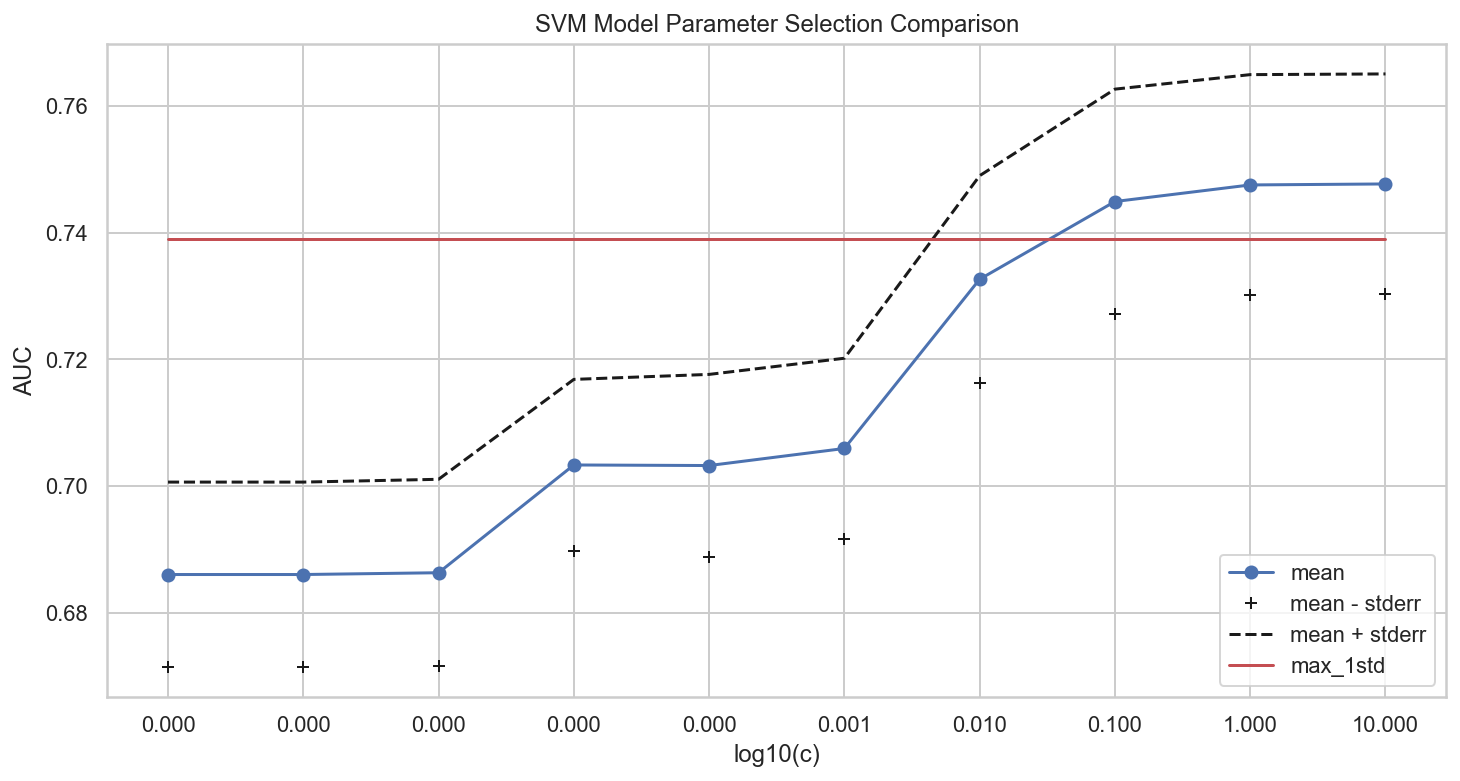

In [254]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.set_xscale('log')
ax.set_xticks(cs)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.plot(df1.index, df1["mean"],'bo-', label="mean")
plt.plot(df1.index, df1["mean"]-df1["stderr"]*2, "k+", label="mean - stderr")
plt.plot(df1.index, df1["mean"]+df1["stderr"]*2, "k--", label="mean + stderr")
plt.plot(df1.index, df1["max_1std"], "r-", label="max_1std")

plt.xlabel('log10(c)')
plt.ylabel('AUC')
plt.title('SVM Model Parameter Selection Comparison')
plt.legend(loc="lower right")
plt.show()

Did the model parameters selected beat the out-of-the-box model for SVM? 

No, none of the selected model parameters beats the out-of-the-box model: The original model parameter 10 is still the best parameter as you look at the plot, parameter c = 10 has the highest AUC score among 10 selected parameters. 
We can see that auc score is being constant starting from c= 0.1 but the out-of-box SVM model uses roc score where c=10.

### Learning Curve with Bootstrapping 

Here I am trying to find the best linear model to predict if a record represents the Higgs Boson. One of the drivers of the performance of a model is the sample size of the training set.  As a data scientist, sometimes you have to decide if you have enough data or if you should invest in more.  We can use learning curve analysis to determine if we have reached a performance plateau. This will inform us on whether or not we should invest in more data (in this case it would be by running more experiments).

Given a training set of size $N$, I will test the performance of a model trained on a subsample of size $N_i$, where $N_i<=N$.  I can plot how performance grows as we move $N_i$ from $0$ to $N$.  

Because of the inherent randomness of subsamples of size $N_i$, we should expect that any single sample of size $N_i$ might not be representative of an algorithm’s performance at a given training set size. To quantify this variance and get a better generalization, we will also use bootstrap analysis. In bootstrap analysis, we pull multiple samples of size $N_i$, build a model, evaluate on a test set, and then take an average and standard error of the results.

1\. I will create a bootstrap function that can do the following:

def modBootstrapper(train, test, nruns, sampsize, lr, c):

-	Takes as input:
    -	A master training file (train)
    -	A master testing file (test)
    -	Number of bootstrap iterations (nruns) 
    -	Size of a bootstrap sample (sampsize)
    -	An indicator variable to specific LR or SVM (lr=1)
    -	A c option (only applicable to SVM)

-	Runs a loop with (nruns) iterations, and within each loop:
    -	Sample (sampsize) instances from train, with replacement
    -	Fit either an SVM or LR (depending on options specified). For SVM, use the linear kernel and value of C identified using the 1 standard error method from part 3. For LR, use the default C.  
    -	Computes AUC on test data using predictions from model in above step
    -	Stores the AUC in a list
    
-	Returns the mean(AUC) and Standard Deviation(AUC) across all bootstrap samples. Note: the standard error of the mean AUC is really the standard deviation of the bootstrapped distribution, so I just used np.sqrt(np.var(...))


In [255]:
# Code here
def modBootstrapper(train, test, nruns, sampsize, lr, c):
    aucs_ls= []

    for i in range(nruns):
        sample_train = train.iloc[np.random.randint(0, len(train), size=sampsize)]
        X = sample_train.drop('Y', 1)
        Y = sample_train['Y']
        
        if lr == 1:
            lr_model = LogisticRegression(C=c).fit(X, Y)
            preds = lr_model.predict_proba(test.drop("Y", 1))[:,1]
        else:
            svm_model = SVC(C=c, kernel="linear").fit(X, Y)
            preds = svm_model.decision_function(test.drop("Y", 1))
        
        aucs_ls.append(roc_auc_score(test['Y'], preds))
    
    mean_auc = np.mean(aucs_ls)
    std_auc = np.sqrt(np.var(aucs_ls))
    
    return [mean_auc, std_auc]

2\. For both LR and SVM, I will run 20 bootstrap samples for each samplesize in the following list: samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]. For SVM, I will use the value of C identified using the 1 standard error method. For LR, I will use the default C.

I will generate a plot with the following:
-	Log2(samplesize) on the x-axis
-	2 sets of results lines, one for LR and one for SVM, the set should include
    -	1 series with mean(AUC) for each sampsize (use the color options ‘g’ for svm, ‘r’ for lr)
    -	1 series with mean(AUC)-2*stddev(AUC) (note: standard deviation, not standard error) for each samp size (use ‘+’ as color pattern, ‘g’,’r’ for SVM, LR respectively)
    -	1 series with mean(AUC)+2*stddev(AUC) (note: standard deviation, not standard error) for each samp size (use ‘--‘ as color pattern ‘g’,’r’ for SVM, LR respectively)


In [256]:
samplesizes = [50, 100, 200, 500, 1000, 1500, 2000]

lr_mean={}
lr_std={}
svm_mean={}
svm_std={}

for i in samplesizes:
    mean_LR, std_LR = modBootstrapper(data_train, data_test, 20, i, 1, 1.0) # default c =1 for LR
    lr_mean[i] = mean_LR
    lr_std[i] = std_LR
        
    mean_SVM, std_SVM = modBootstrapper(train=data_train, test=data_test, nruns=20, sampsize=i, lr=0, c=0.1)      
    svm_mean[i] = mean_SVM
    svm_std[i] = std_SVM

In [257]:
dicts = [lr_mean, lr_std, svm_mean, svm_std]
dicts

[{50: 0.7112307609900654,
  100: 0.7220920837081305,
  200: 0.745586922735217,
  500: 0.76021063209941,
  1000: 0.7695051986196473,
  1500: 0.7701531738365596,
  2000: 0.7718746978198435},
 {50: 0.05189523099021124,
  100: 0.027375895989422826,
  200: 0.02168844396192821,
  500: 0.010264663830391657,
  1000: 0.004075760664750251,
  1500: 0.002320774789719426,
  2000: 0.00181635899206953},
 {50: 0.6866382128015853,
  100: 0.7118398966555021,
  200: 0.7281807955805415,
  500: 0.7360694478771782,
  1000: 0.7476173333148728,
  1500: 0.7503006438656067,
  2000: 0.7513928143420324},
 {50: 0.04753968240977742,
  100: 0.03603679994113033,
  200: 0.023586490048030564,
  500: 0.019868268168455532,
  1000: 0.015334210750546926,
  1500: 0.013016240222625151,
  2000: 0.007756534523533707}]

In [258]:
df_bs = pd.DataFrame(dicts).T
df_bs.columns = ["lr_mean", "lr_std", "svm_mean", "svm_std"]
df_bs

,lr_mean,lr_std,svm_mean,svm_std
50,0.711231,0.051895,0.686638,0.047540
100,0.722092,0.027376,0.711840,0.036037
200,0.745587,0.021688,0.728181,0.023586
500,0.760211,0.010265,0.736069,0.019868
1000,0.769505,0.004076,0.747617,0.015334
1500,0.770153,0.002321,0.750301,0.013016
2000,0.771875,0.001816,0.751393,0.007757


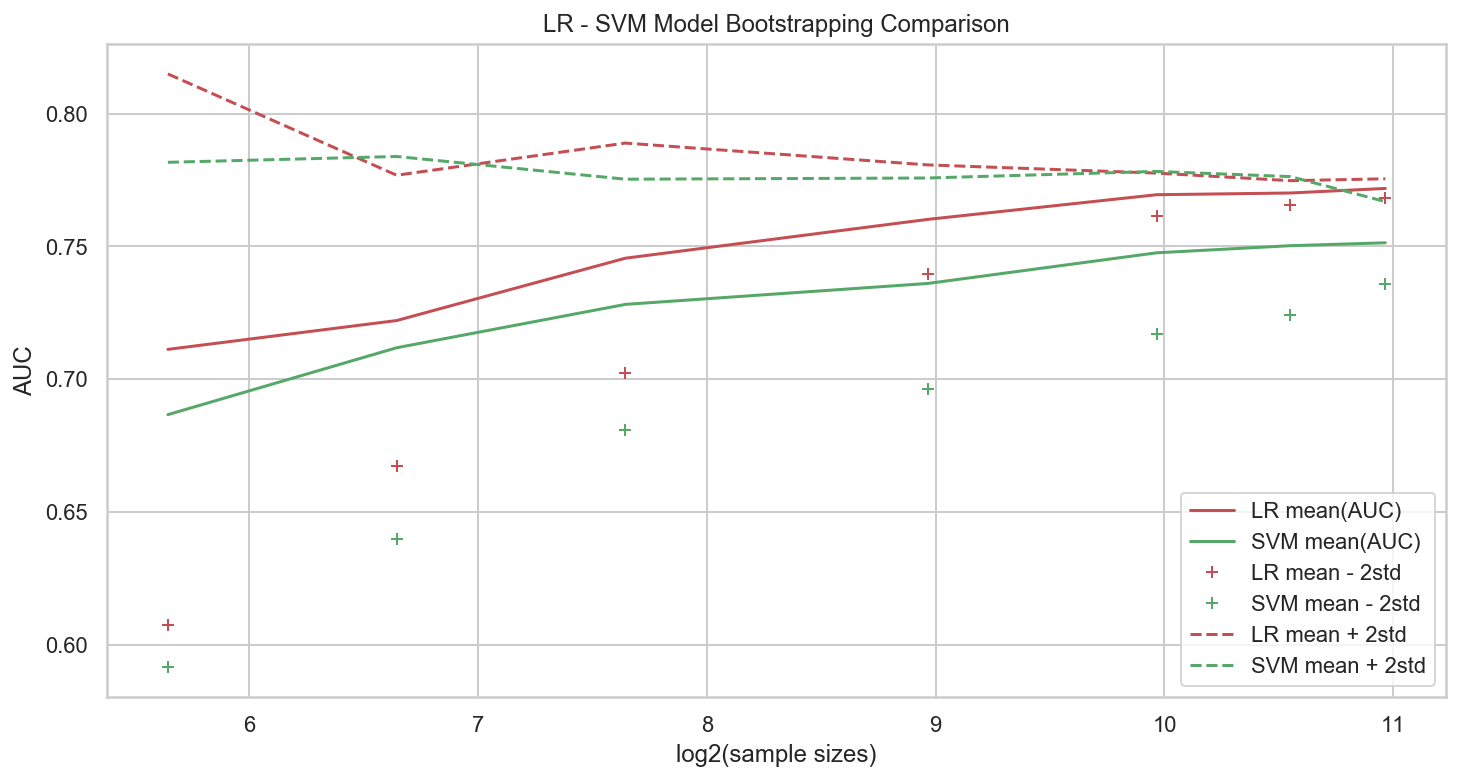

In [259]:
plt.figure(figsize=(12, 6))
ax = plt.gca()
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.plot(np.log2(samplesizes), df_bs["lr_mean"],'r', label="LR mean(AUC)")
plt.plot(np.log2(samplesizes), df_bs["svm_mean"],'g', label="SVM mean(AUC)")

plt.plot(np.log2(samplesizes), df_bs["lr_mean"]-df_bs["lr_std"]*2, "r+", label="LR mean - 2std")
plt.plot(np.log2(samplesizes), df_bs["svm_mean"]-df_bs["svm_std"]*2, "g+", label="SVM mean - 2std")

plt.plot(np.log2(samplesizes), df_bs["lr_mean"]+df_bs["lr_std"]*2, "r--", label="LR mean + 2std")
plt.plot(np.log2(samplesizes), df_bs["svm_mean"]+df_bs["svm_std"]*2, "g--", label="SVM mean + 2std")


plt.xlabel('log2(sample sizes)')
plt.ylabel('AUC')
plt.title('LR - SVM Model Bootstrapping Comparison')
plt.legend(loc="lower right")
plt.show()

3\. Which of the two algorithms are more suitable for smaller sample sizes, given the set of features? If it costs twice the investment to run enough experiments to double the data, do you think it is a worthy investment?

As we can see from the above graph, LR performs better for both smaller and larger sample sizes, across all the sample sizes.
I don't think it's worthy investment to pay twice as much to run experiments to double the data. For the sample size of log2(6), roc score is around 0.70 compared to 0.76 around the sample size of log2(11). This is not a huge difference. Also, both algorithms reach the maximum roc score value as we can see it being plateau, doubling data will not likely add that much value in the case of this particular dataset, as it costs a lot!

4\. Is there a reason why cross-validation might be biased? If so, in what direction is it biased?



Because we used k-fold cross-valudation, after we split the dataset into k equally partitioned subsets, we only use $\frac{k-1}{k}$ of them for training, which will be evaliated on the rest of them. As we do cross-validation, we know that there is no overlap between the test sets on which the model is evaluated, but there exists overlapping between training sets. Thus, we overestimate the prediction error, so we can say that cross-validation or estimates of prediction is optimistically biased upward due to the smaller training sample size.
